In [52]:
%pip install -qU seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [53]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sns.set(style='whitegrid')

In [10]:
with open(os.path.join("..", "data", "dataset.json"), 'r') as f:
    data = json.load(f)

examples = pd.DataFrame(data)

In [12]:
examples[:5]

,prefix,middle,suffix,completion,label,metrics
0,"""""""\nThis module sets up and runs the FastAPI ...",app.include_router(agent_router)\n,"\n\ndef main():\n """"""\n Entry point to r...","\n\n@app.get(""/"")\nasync def root():\n retu...",0.0,"{'exact_match': 0, 'bleu': 0, 'chrf': 0.171324..."
1,"""""""\nThis module sets up and runs the FastAPI ...","uvicorn.run(""cmd_chain.server:app"", host=""...","\n\nif __name__ == ""__main__"":\n main()\n","\n\nif __name__ == ""__main__"":\n uvicorn.ru...",1.0,"{'exact_match': 0, 'bleu': 0.04879500364742666..."
2,"""""""\nThis module sets up and runs the FastAPI ...",from dotenv import load_dotenv\n,from fastapi import FastAPI\n\nfrom cmd_chain....,"\n\ndef create_app():\n """"""\n Creates th...",0.5,"{'exact_match': 0, 'bleu': 0, 'chrf': 0.129151..."
3,"""""""\nThis module sets up and runs the FastAPI ...",Entry point to run the FastAPI server usin...,"""""""\n uvicorn.run(""cmd_chain.server:app...",\n\tThis function runs the FastAPI server.\n\t...,1.0,"{'exact_match': 0, 'bleu': 0.09759000729485329..."
4,"""""""\nThis module sets up and runs the FastAPI ...",\n,from cmd_chain.agent import agent_router\n\nlo...,\n\nload_dotenv()\n\napp = FastAPI()\n\n@app.g...,1.0,"{'exact_match': 0, 'bleu': 0, 'chrf': 1e-16, '..."


In [13]:
print("Dataset Overview:")
print(examples.info())
print("\nSummary Statistics:")
print(examples.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prefix      40 non-null     object 
 1   middle      40 non-null     object 
 2   suffix      40 non-null     object 
 3   completion  40 non-null     object 
 4   label       40 non-null     float64
 5   metrics     40 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.0+ KB
None

Summary Statistics:
          label
count  40.00000
mean    0.32500
std     0.40112
min     0.00000
25%     0.00000
50%     0.00000
75%     0.50000
max     1.00000


**Notes**

- **Data Quality**:
  - No missing values are present, indicating that the dataset is complete, which is ideal for analysis.
  - The dataset consists of **40 examples**, with each having fields for the prefix, middle, suffix, completion, label, and metrics.

- **Label Summary Statistics**:
  - The **mean label value** is `0.325`, which indicates that the majority of examples are **incorrect** (`label = 0`).
  - The **standard deviation** of `0.401` suggests significant variability in the labels.
  - The **quartiles** (25%, 50%, and 75%) show that **50% of the examples are labeled as incorrect**, while **only 25%** have a label of **0.5 or higher**.

/tmp/ipykernel_214752/2550623975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=examples, palette='viridis')


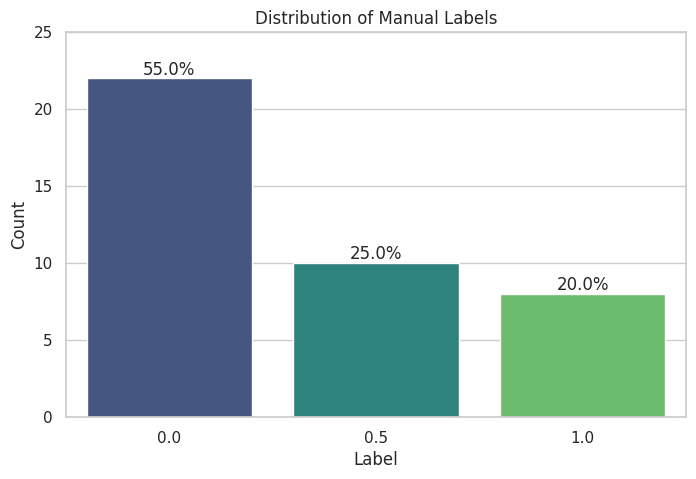

In [45]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=examples, palette='viridis')
plt.title('Distribution of Manual Labels')
plt.xlabel('Label')
plt.ylabel('Count')

label_counts = examples['label'].value_counts(normalize=True) * 100
for index, value in enumerate(label_counts):
    plt.text(index, 0.4 * value, f'{value:.1f}%', ha='center', fontsize=12, va='bottom')

plt.ylim(0, max(label_counts) - 30)
plt.show()

**Notes**

- The label distribution reveals that **55% of the examples** are labeled as incorrect (`label = 0`), while **20%** are labeled as correct (`label = 1`), and **25%** as partially correct (`label = 0.5`).
- **Imbalance in Labels**: 
  - The dataset is **skewed towards incorrect completions**. This imbalance could impact the ability to detect patterns in the metrics for correct completions and may bias the correlation analysis.
- **Next Steps**:
  - It could be helpful to consider **oversampling** correct completions in future dataset iterations or at least be mindful of how this imbalance might influence the conclusions.

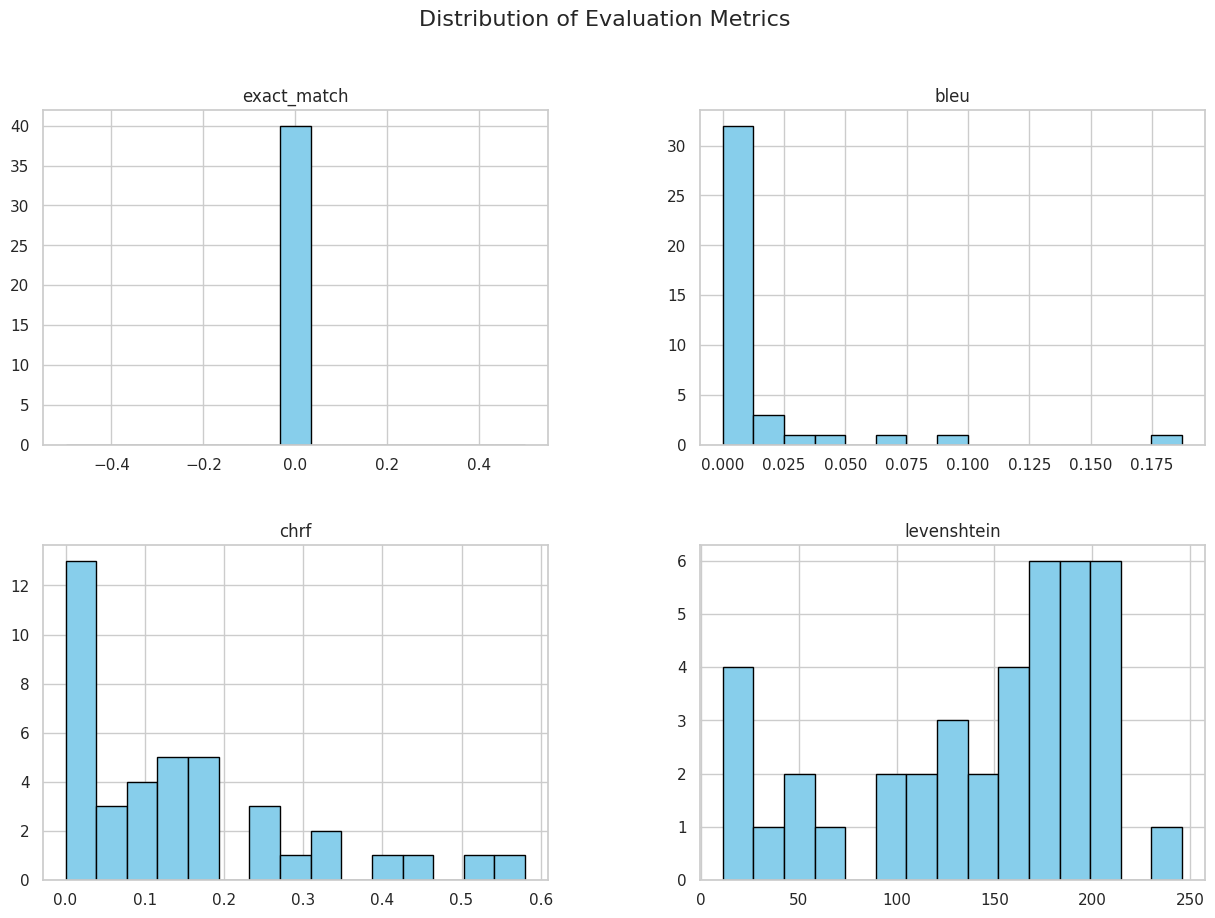

In [18]:
# Separate metrics into a new DataFrame
metrics_df = pd.DataFrame(list(examples['metrics']))

# Plot histograms for each metric to understand distribution
metrics_df.hist(figsize=(15, 10), bins=15, color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Evaluation Metrics', fontsize=16)
plt.show()

**Notes**
Here we see the distributions of each metric and they tells us several things:

- **Exact Match**:
  - Since **no completions matched exactly**, this metric is indeed **useless for further analysis**.
  - Dropping it is a good decision, as it provides no value given the current results.
- **BLEU Score**:
  - The **distribution** shows some potential value, but the metric may not be optimal for code. The **CodeBLEU** metric would be more suitable for evaluating code-specific nuances.
  - **Keep it** in further analysis to see if it provides some value despite its limitations.
- **ChrF Score**:
  - The **similarity in shape** between the ChrF score distribution and manual labels suggests that this metric could correlate well with the manual evaluation.
  - **Focus on ChrF** in the upcoming analysis to confirm if it can serve as a reliable metric.
- **Levenshtein Distance**:
  - The **varied distribution** indicates that the metric may not align well with the labels. Different implementations that achieve similar outcomes may result in a high Levenshtein distance, leading to poor correlation.
  - **Keep it in analysis** for now, but be cautious—high Levenshtein values may simply indicate stylistic differences rather than incorrect completions.

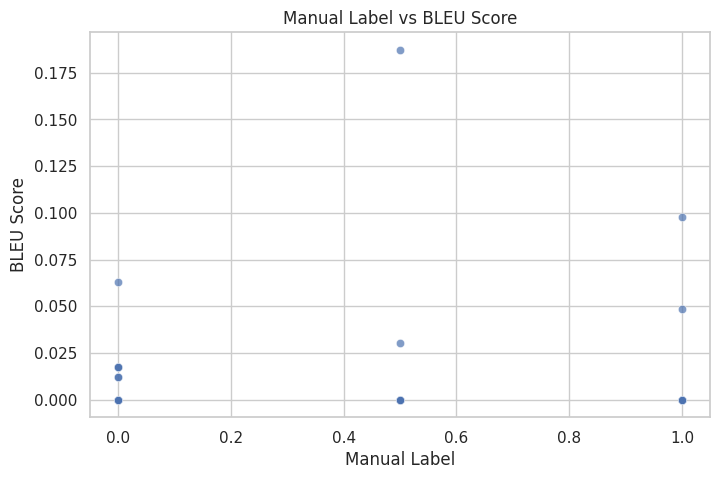

In [19]:
# Scatter plot to see correlation between manual labels and BLEU scores
plt.figure(figsize=(8, 5))
sns.scatterplot(x=examples['label'], y=metrics_df['bleu'], alpha=0.7)
plt.title('Manual Label vs BLEU Score')
plt.xlabel('Manual Label')
plt.ylabel('BLEU Score')
plt.show()

**Notes**

- **Weak Correlation**:
  - The scatter plot reveals a **weak relationship** between BLEU scores and manual labels.
  - Many **high BLEU scores** were assigned to examples with `label = 0` (incorrect), which indicates that **BLEU might not adequately capture correctness** for code, possibly due to stylistic differences in the completions.
- **Next Steps**:
  - It would be useful to check the correlation coefficients of other metrics to understand if **ChrF** or **Levenshtein** performs better.

In [21]:
# Calculate correlation coefficients between labels and each metric
correlations = {}
for metric in ['bleu', 'chrf', 'levenshtein']:
    correlation, _ = pearsonr(examples['label'], metrics_df[metric])
    correlations[metric] = correlation
    print(f'Correlation between manual label and {metric}: {correlation:.3f}')

Correlation between manual label and bleu: 0.169
Correlation between manual label and chrf: -0.039
Correlation between manual label and levenshtein: -0.137


**Notes**

- **Correlation Coefficients**:
  - **BLEU Score**: The correlation with manual labels is **0.169**, indicating a very **weak positive correlation**. This confirms the earlier observation that BLEU may not be very effective in evaluating correctness for code completions.
  - **ChrF Score**: The correlation is **-0.039**, indicating **no meaningful relationship**. This contradicts the earlier assumption that ChrF might align with manual labels, suggesting further exploration might be needed to explain this.
  - **Levenshtein Distance**: The correlation is **-0.137**, which shows a **slight negative relationship**. This means that as Levenshtein distance increases, the likelihood of the completion being correct decreases. However, the low magnitude suggests this is not a strong or reliable metric either.

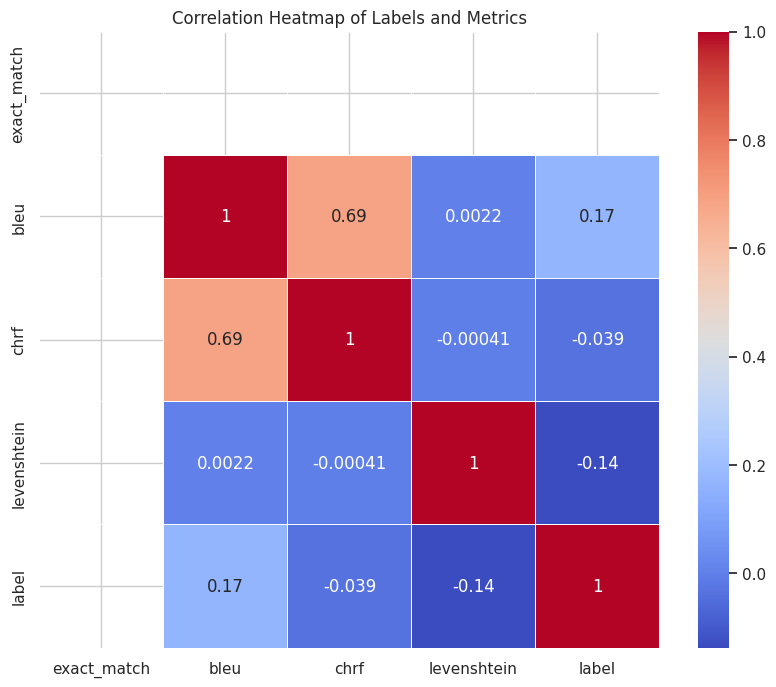

In [46]:
# Create a heatmap of correlations between metrics
corr_matrix = metrics_df.join(examples['label']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Labels and Metrics')
plt.show()

**Notes**

- **High Correlation Between BLEU and ChrF** (`0.69`):
  - There is a relatively strong positive correlation (`0.69`) between **BLEU** and **ChrF** scores.
  - This suggests that both metrics often agree on their evaluation, indicating some redundancy between these metrics.
- **Weak Correlation Between BLEU and Manual Label** (`0.17`):
  - **BLEU** has a weak positive correlation (`0.17`) with **manual labels**, meaning that BLEU scores do not reliably predict whether a completion is labeled as correct or partially correct.
- **No Meaningful Correlation with ChrF and Levenshtein**:
  - **ChrF** and **Levenshtein** both have near-zero or negative correlations with the **manual labels** (`-0.039` for ChrF and `-0.14` for Levenshtein).
  - This suggests that neither of these metrics are good indicators of manual evaluation quality in this dataset.
  
#### **Conclusions from Heatmap**:
- **BLEU and ChrF are Redundant**: Given their high correlation, it may not be necessary to use both in future analyses. Either metric could represent the other with a similar level of effectiveness.
- **Metrics Do Not Reliably Predict Label Quality**: The low correlation between **manual labels** and all the metrics highlights that these metrics might not adequately capture the quality of code completions.

/tmp/ipykernel_214752/2214912098.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], y=metrics_df['bleu'], palette='viridis')
/tmp/ipykernel_214752/2214912098.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], y=metrics_df['chrf'], palette='viridis')
/tmp/ipykernel_214752/2214912098.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], y=metrics_df['levenshtein'], palette='viridis')


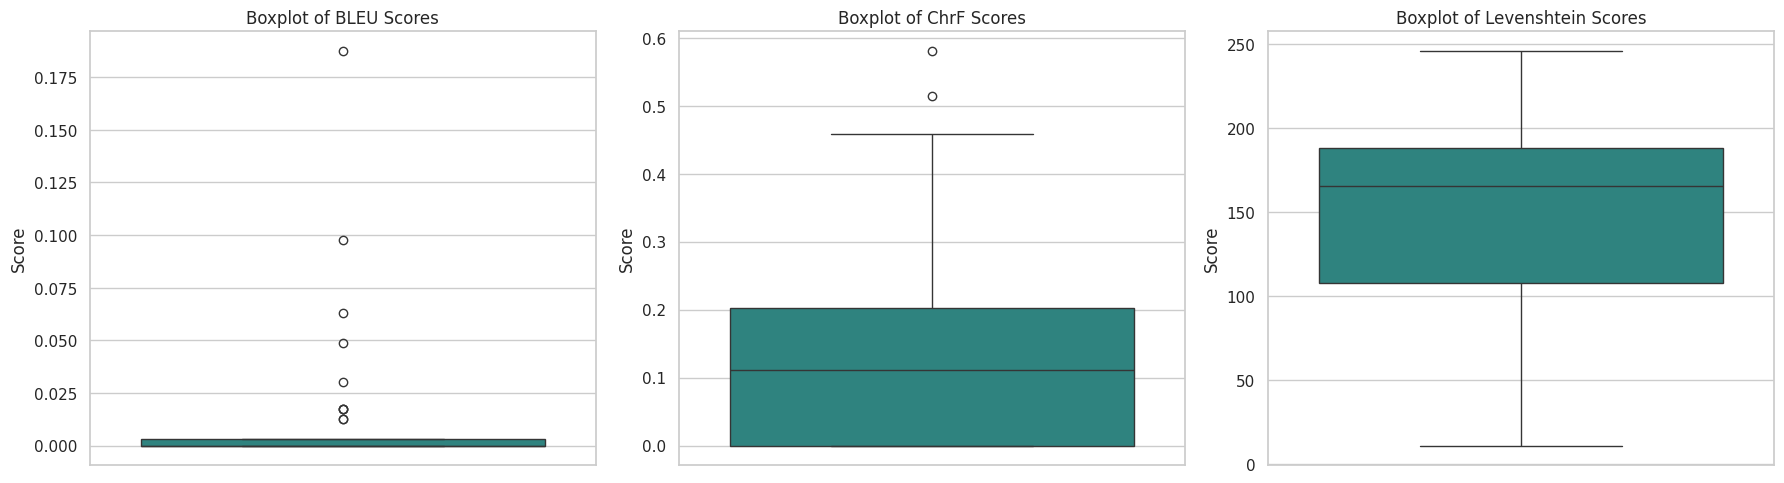

In [54]:
# Create boxplots of each metric to show outliers in their distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], y=metrics_df['bleu'], palette='viridis')
axes[0].set_title('Boxplot of BLEU Scores')
axes[0].set_ylabel('Score')

sns.boxplot(ax=axes[1], y=metrics_df['chrf'], palette='viridis')
axes[1].set_title('Boxplot of ChrF Scores')
axes[1].set_ylabel('Score')

sns.boxplot(ax=axes[2], y=metrics_df['levenshtein'], palette='viridis')
axes[2].set_title('Boxplot of Levenshtein Scores')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

**Notes**

- **BLEU Score Boxplot**:
  - The **BLEU** scores have a large number of **outliers**. The majority of the values are clustered near zero, with a few instances of significantly higher scores.
  - This suggests that BLEU often assigns very low scores to completions, with occasional completions getting higher scores, likely due to coincidental n-gram overlap rather than actual quality.
- **ChrF Score Boxplot**:
  - The **ChrF** score distribution shows a wider spread compared to BLEU, with several outliers.
  - Most of the scores are centered in interval **[0, 0.2]**, suggesting that while there is some overlap between completions and the reference, the quality is still generally low. The outliers may represent cases where the generated code matched the reference more closely at the character level.
- **Levenshtein Distance Boxplot**:
  - The **Levenshtein Distance** has the largest variability, ranging from values near zero up to over **200**.
  - The spread indicates that completions vary widely in their similarity to the reference, with some completions being very close (low distance) and others being very far off (high distance). This wide spread suggests a mix of both correct and incorrect completions.

#### **Conclusions from Outlier Analysis**:
- **BLEU and ChrF Metrics**: Both metrics have several outliers, and most scores are clustered towards lower values, indicating that the generated completions generally did not match the reference well.
- **Levenshtein Distance**: The large spread and variability show that completions are inconsistent, with some being close to correct and others far off. This aligns with the weak correlation seen in the heatmap.

### **Final Conclusions for the Whole Analysis**:

1. **Metric Effectiveness**:
   - **BLEU, ChrF, and Levenshtein** do not correlate well with the **manual labels**, indicating they are not reliable indicators of code completion quality in this dataset.
   - **Exact Match** was particularly useless, as no completions matched exactly, and it was dropped from the analysis.

2. **Redundancy**:
   - **BLEU** and **ChrF** scores have a strong correlation (`0.69`), suggesting redundancy. Given their similar evaluation characteristics, using both is unnecessary—one of them can be dropped.

3. **Label Distribution and Dataset Imbalance**:
   - The dataset has a significant imbalance with a majority of examples labeled as incorrect (`0`). This imbalance may be contributing to the difficulty in achieving reliable metric correlations, as there are fewer examples of positive completions for the metrics to learn from.

4. **Metric Limitations**:
   - The poor performance of **BLEU** and **ChrF** could be attributed to their focus on **n-gram and character-level overlap**, which may not capture the logical correctness or functionality of code.
   - The **Levenshtein Distance** measures how different the generated and reference code are, but this metric does not account for stylistic differences, which can lead to high distances even for functionally correct code.

### **Recommendations for Future Work**:

1. **Use Code-Specific Metrics**:
   - Consider using metrics specifically designed for evaluating code, such as **CodeBLEU**, which takes into account syntax, structure, and semantic features.

2. **Increase Dataset Balance**:
   - Try to balance the dataset with more **correct** and **partially correct** completions, which could help reveal more nuanced patterns in metric effectiveness.

3. **Refine Metric Selection**:
   - Given the redundancy between BLEU and ChrF, drop one of them (e.g., **BLEU**) and explore alternatives that capture code-specific nuances.

4. **Qualitative Analysis**:
   - A qualitative examination of outliers, especially those with high BLEU or ChrF scores but incorrect manual labels, might provide insights into why these metrics fail to align with human judgment.

5. **Consider Human-in-the-Loop Evaluation**:
   - Incorporate manual human evaluations alongside metrics to get a clearer understanding of code correctness, functionality, and logical flow, since automated metrics struggled to capture these aspects accurately.